## Imports

In [95]:
%load_ext autoreload
%autoreload 2

import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

import pickle
from multiprocessing import Pool

import modeling
import helpers
import plotting
import scienceplots
plt.style.use(['science','no-latex'])
# plt.style.use(['science','ieee','no-latex'])

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load data

In [96]:
with open('data.pkl', 'rb') as file:
    data_dict = pickle.load(file)
    all_data = data_dict['data']
    meta_data = data_dict['meta_data']

## Fit models

In [97]:
num_subject = all_data['tr'].shape[0]

alpha_bounds = [1e-6, 1]
beta_bounds = [1e-6, 10]
beta_meta_bounds = [0, 5]
concentration_bounds = [-2, 1]
v_repeat_bounds = [-10, 1]
prior_bounds = [0.01, 0.98]
bounds = [alpha_bounds, beta_bounds, beta_meta_bounds, concentration_bounds, v_repeat_bounds, prior_bounds] 
param_names = ['lr', 'beta_base', 'beta_meta', 'concentration', 'v_repeat', 'prior']

### Backward structured model without meta-learning (fitted to Blocks 1-6)

In [98]:
this_model = 'option_model'
structure = 'backward'
meta_learning = False

best_llh_all = np.zeros(num_subject)
best_params_all = np.zeros((num_subject, len(param_names)))

D = helpers.get_model_fit_data(all_data, num_block=6)

if __name__ == "__main__":
    inputs = []
       
    for i in range(num_subject):
        inputs.append((this_model, D[D[:,0]==i,:], structure, i, bounds, meta_learning))

    with Pool() as p:
        results = p.map(modeling.parallel_worker, inputs)

    for i, best_params, best_llh in results:
        best_params_all[i, :], best_llh_all[i] = best_params, best_llh

np.save('fitting_results/'+structure+'_no_meta_params.npy', best_params_all)
np.save('fitting_results/'+structure+'_no_meta_llh.npy', best_llh_all)

### Backward structured model (fitted to Blocks 1-6)

In [99]:
this_model = 'option_model'
structure = 'backward'
meta_learning = True

best_llh_all = np.zeros(num_subject)
best_params_all = np.zeros((num_subject, len(param_names)))

D = helpers.get_model_fit_data(all_data, num_block=6)

if __name__ == "__main__":
    inputs = []
       
    for i in range(num_subject):
        inputs.append((this_model, D[D[:,0]==i,:], structure, i, bounds, meta_learning))

    with Pool() as p:
        results = p.map(modeling.parallel_worker, inputs)

    for i, best_params, best_llh in results:
        best_params_all[i, :], best_llh_all[i] = best_params, best_llh

np.save('fitting_results/'+structure+'_blocks1-6_params.npy', best_params_all)
np.save('fitting_results/'+structure+'_blocks1-6_llh.npy', best_llh_all)

### Temporally backward model

In [100]:
this_model = 'option_model'
structure = 'backward'
meta_learning = True

best_llh_all = np.zeros(num_subject)
best_params_all = np.zeros((num_subject, len(param_names)))

D = helpers.get_model_fit_data(all_data, num_block=12)

if __name__ == "__main__":
    inputs = []
       
    for i in range(num_subject):
        inputs.append((this_model, D[D[:,0]==i,:], structure, i, bounds, meta_learning))

    with Pool() as p:
        results = p.map(modeling.parallel_worker, inputs)

    for i, best_params, best_llh in results:
        best_params_all[i, :], best_llh_all[i] = best_params, best_llh

np.save('fitting_results/'+structure+'_params.npy', best_params_all)
np.save('fitting_results/'+structure+'_llh.npy', best_llh_all)


### Temporally forward model

In [119]:
this_model = 'option_model'
structure = 'forward'
meta_learning = True

best_llh_all = np.zeros(num_subject)
best_params_all = np.zeros((num_subject, len(param_names)))

D = helpers.get_model_fit_data(all_data, num_block=12)

if __name__ == "__main__":
    inputs = []
       
    for i in range(num_subject):
        inputs.append((this_model, D[D[:,0]==i,:], structure, i, bounds, meta_learning))

    with Pool() as p:
        results = p.map(modeling.parallel_worker, inputs)

    for i, best_params, best_llh in results:
        best_params_all[i, :], best_llh_all[i] = best_params, best_llh

np.save('fitting_results/'+structure+'_params.npy', best_params_all)
np.save('fitting_results/'+structure+'_llh.npy', best_llh_all)

## Plot fit

### Set up

In [120]:
# Load fitted parameters
best_params_all_backward_no_meta = np.load('fitting_results/backward_no_meta_params.npy')
best_params_all_backward_first6 = np.load('fitting_results/backward_blocks1-6_params.npy')
best_params_all_forward = np.load('fitting_results/forward_params.npy')
best_params_all_backward = np.load('fitting_results/backward_params.npy')

best_llh_all_backward_no_meta = np.load('fitting_results/backward_no_meta_llh.npy')
best_llh_all_backward_first6 = np.load('fitting_results/backward_blocks1-6_llh.npy')
best_llh_all_forward = np.load('fitting_results/forward_llh.npy')
best_llh_all_backward = np.load('fitting_results/backward_llh.npy')

niters_sim = 10
this_model = 'option_model'
cluster = 0

### Model selection

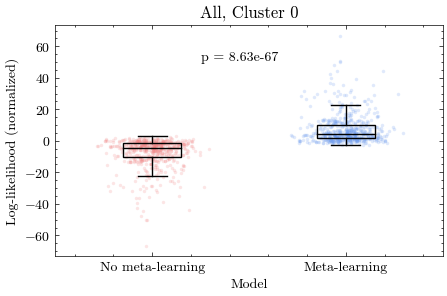

In [121]:
aic_backward_no_meta = -2*best_llh_all_backward_no_meta + 2*4
aic_backward_first6 = -2*best_llh_all_backward_first6 + 2*5
llh_mean = (best_llh_all_backward_no_meta + best_llh_all_backward_first6) / 2
condition = 'All'
plt.figure(figsize=(5,3))
inds = (meta_data['Cluster']==cluster)
this_llh_mean = llh_mean[inds]
noise = np.random.normal(0, 0.1, np.sum(inds))
m1_fit_metric = (best_llh_all_backward_no_meta[inds] - this_llh_mean)
m2_fit_metric = (best_llh_all_backward_first6[inds] - this_llh_mean)
t_stat, p_value = stats.ttest_rel(m1_fit_metric, m2_fit_metric, alternative='less')
plt.plot(np.ones(np.sum(inds))+noise, m1_fit_metric, '.', mew=0, ms=5, color='lightcoral', alpha=0.2)
plt.plot(np.ones(np.sum(inds))*2+noise, m2_fit_metric, '.', mew=0, ms=5, color='cornflowerblue', alpha=0.2)
plt.boxplot([m1_fit_metric, m2_fit_metric], sym='', widths=0.3, patch_artist=True, boxprops=dict(facecolor='none', color='black'), whiskerprops=dict(color='black'), medianprops=dict(color='black'), capprops=dict(color='black'))
plt.text(1.25, max(max(m1_fit_metric), max(m2_fit_metric))-10, f'p = {p_value:.2e}', horizontalalignment='left', verticalalignment='top')
plt.xlim(0.5,2.5)
plt.xticks([1,2], ['No meta-learning', 'Meta-learning'])
plt.xlabel('Model')
plt.ylabel('Log-likelihood (normalized)')
plt.title(f'{condition}, Cluster {cluster}')
plt.show()

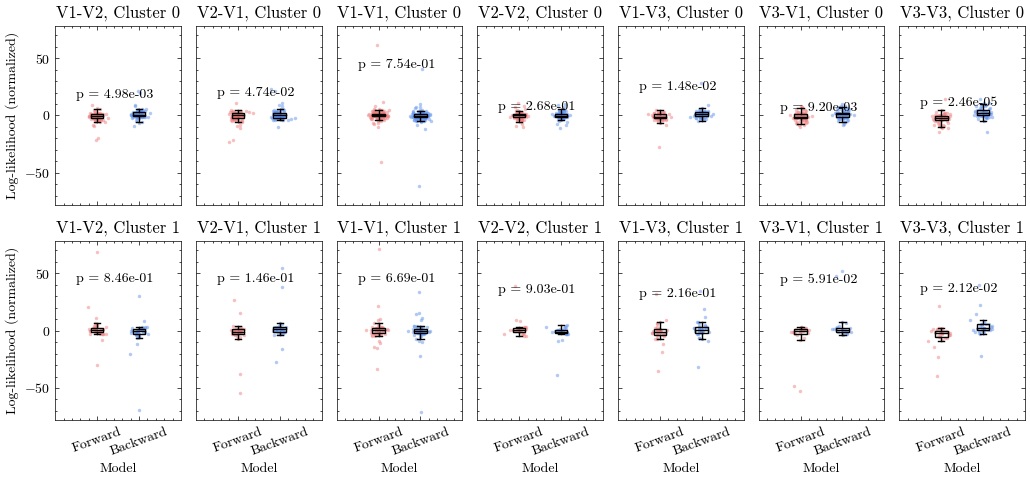

In [122]:
llh_mean = (best_llh_all_forward + best_llh_all_backward) / 2
clusters = [0, 1]
conditions = ['V1-V2', 'V2-V1', 'V1-V1', 'V2-V2', 'V1-V3', 'V3-V1', 'V3-V3']
plt.subplots(len(clusters),len(conditions),figsize=(1.5*len(conditions), 5),sharex=True, sharey=True)
for this_cluster in clusters:
    for c, condition in enumerate(conditions):
        plt.subplot(len(clusters),len(conditions),c+1+this_cluster*len(conditions))
        inds = (meta_data['Cluster']==this_cluster) & (meta_data['Condition']==condition)
        this_llh_mean = llh_mean[inds]
        noise = np.random.normal(0, 0.1, np.sum(inds))
        m1_fit_metric = (best_llh_all_forward[inds] - this_llh_mean)
        m2_fit_metric = (best_llh_all_backward[inds] - this_llh_mean)
        # Compute the one-tailed paired t-test
        t_stat, p_value = stats.ttest_rel(m1_fit_metric, m2_fit_metric, alternative='less')
        plt.plot(np.ones(np.sum(inds))+noise, m1_fit_metric, '.', mew=0, ms=5, color='lightcoral', alpha=0.5)
        plt.plot(np.ones(np.sum(inds))*2+noise, m2_fit_metric, '.', mew=0, ms=5, color='cornflowerblue', alpha=0.5)
        plt.boxplot([m1_fit_metric, m2_fit_metric], sym='', widths=0.3, patch_artist=True, boxprops=dict(facecolor='none', color='black'), whiskerprops=dict(color='black'), medianprops=dict(color='black'), capprops=dict(color='black'))
        plt.xlim(0,3)
        plt.text(0.5, min(max(max(m1_fit_metric), max(m2_fit_metric))+2, 50), f'p = {p_value:.2e}', horizontalalignment='left', verticalalignment='top')
        if this_cluster == clusters[-1]:
            plt.xticks([1,2], ['Forward', 'Backward'], rotation=20)
            plt.xlabel('Model')
        else:
            plt.xticks([1,2], ['',''])
        if c == 0:
            plt.ylabel('Log-likelihood (normalized)')
        plt.title(f'{condition}, Cluster {this_cluster}')
plt.tight_layout()
plt.savefig('plots/model_selection.svg', dpi=1200)

### All (first 6 blocks)

In [123]:
subject_inds = (meta_data['Cluster'] == cluster) 

if __name__ == "__main__":
    inputs = []
    inputs_2 = []
    for i in range(np.sum(subject_inds)):
        params = best_params_all_backward_no_meta[subject_inds][i,:]
        inputs.append((this_model, i, niters_sim, params, 'V1-V1', 'backward', False))
        params = best_params_all_backward_first6[subject_inds][i,:]
        inputs_2.append((this_model, i, niters_sim, params, 'V1-V1', 'backward', True))
        
    with Pool() as p:
        results = p.map(modeling.parallel_simulator, inputs)

    data_sim_backward_no_meta = {}
    for _, this_data in results:
        data_sim_backward_no_meta = helpers.concatenate_data(this_data, data_sim_backward_no_meta)

    with Pool() as p:
        results = p.map(modeling.parallel_simulator, inputs_2)

    data_sim_backward = {}
    for _, this_data in results:
        data_sim_backward = helpers.concatenate_data(this_data, data_sim_backward)

/home/exouser/Desktop/jingjing/learning_hierarchy/helpers.py:918: RuntimeWarning: Mean of empty slice
  mean_population_counter1 = np.hstack((mean_population_counter1_12, np.nanmean(data_counter1[:,:,start_trial:int(start_trial+trials_to_probe)],axis=2)))
/home/exouser/Desktop/jingjing/learning_hierarchy/helpers.py:919: RuntimeWarning: Mean of empty slice
  mean_population_counter2 = np.hstack((mean_population_counter2_12, np.nanmean(data_counter2[:,:,start_trial:int(start_trial+trials_to_probe)],axis=2)))
/home/exouser/Desktop/jingjing/learning_hierarchy/helpers.py:913: RuntimeWarning: Mean of empty slice
  mean_population_counter1_12[sub,0] = np.nanmean(data_counter12_12[sub,0,0,start_trial:int(start_trial+trials_to_probe)])


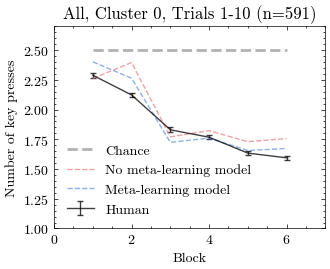

In [124]:
this_data = helpers.slice_data(all_data, meta_data, 'All', exp=[1,2], cluster=cluster)
plotting.plot_validation_n_presses(this_data, data_sim_backward_no_meta, data_sim_backward, 'All', cluster, nblocks=6, m1='No meta-learning', m2='Meta-learning')

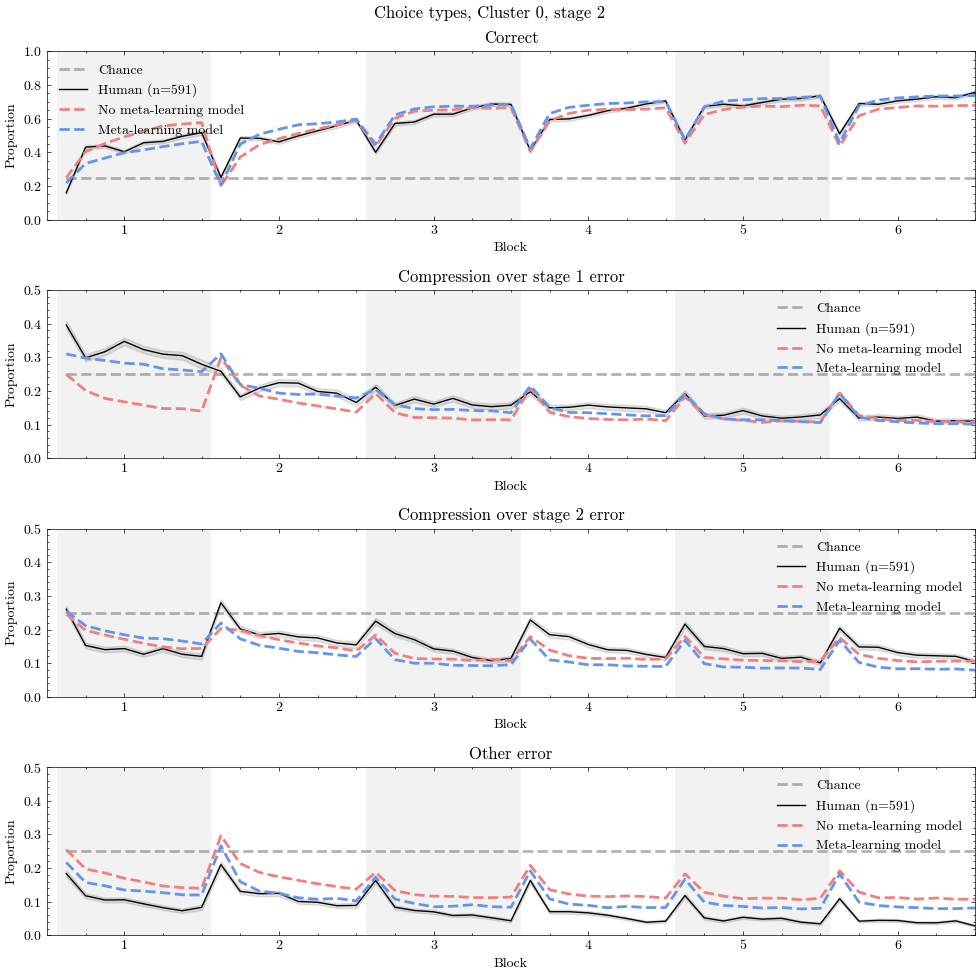

In [125]:
plotting.plot_validation_error_types(this_data, data_sim_backward_no_meta, data_sim_backward, 'All', cluster, nblocks=6, m1='No meta-learning', m2='Meta-learning', save_vector=True)

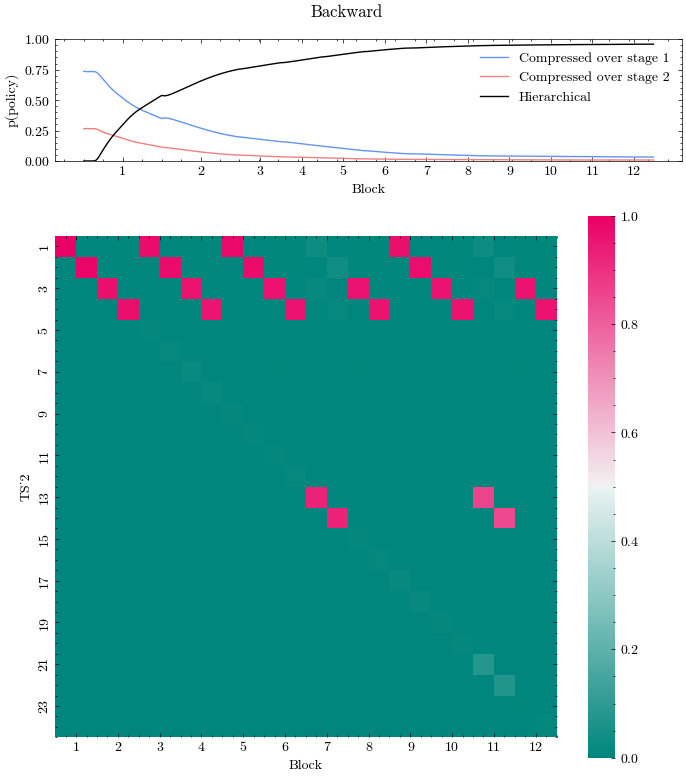

In [126]:
plotting.plot_validation_PTS(data_sim_backward, 'Backward', ntrials=5, cond='V1-V1', save_vector=True, pallette=None)

### V1-V1

In [127]:
condition = 'V1-V1'
subject_inds = (meta_data['Condition'] == condition) & (meta_data['Cluster'] == cluster)

if __name__ == "__main__":
    inputs = []
    inputs_2 = []
    for i in range(best_params_all_forward[subject_inds].shape[0]):
        params = best_params_all_forward[subject_inds][i,:]
        inputs.append((this_model, i, niters_sim, params, condition, 'forward', True))
        params = best_params_all_backward[subject_inds][i,:]
        inputs_2.append((this_model, i, niters_sim, params, condition, 'backward', True))
        
    with Pool() as p:
        results = p.map(modeling.parallel_simulator, inputs)

    data_sim_forward = {}
    for _, this_data in results:
        data_sim_forward = helpers.concatenate_data(this_data, data_sim_forward)

    with Pool() as p:
        results = p.map(modeling.parallel_simulator, inputs_2)

    data_sim_backward = {}
    for _, this_data in results:
        data_sim_backward = helpers.concatenate_data(this_data, data_sim_backward)

/home/exouser/Desktop/jingjing/learning_hierarchy/helpers.py:918: RuntimeWarning: Mean of empty slice
  mean_population_counter1 = np.hstack((mean_population_counter1_12, np.nanmean(data_counter1[:,:,start_trial:int(start_trial+trials_to_probe)],axis=2)))
/home/exouser/Desktop/jingjing/learning_hierarchy/helpers.py:919: RuntimeWarning: Mean of empty slice
  mean_population_counter2 = np.hstack((mean_population_counter2_12, np.nanmean(data_counter2[:,:,start_trial:int(start_trial+trials_to_probe)],axis=2)))


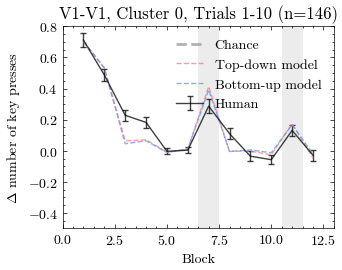

In [128]:
this_data = helpers.slice_data(all_data, meta_data, condition, exp=[1,2], cluster=cluster)
plotting.plot_validation_n_presses(this_data, data_sim_forward, data_sim_backward, condition, cluster, save_vector=True, normalize=True)

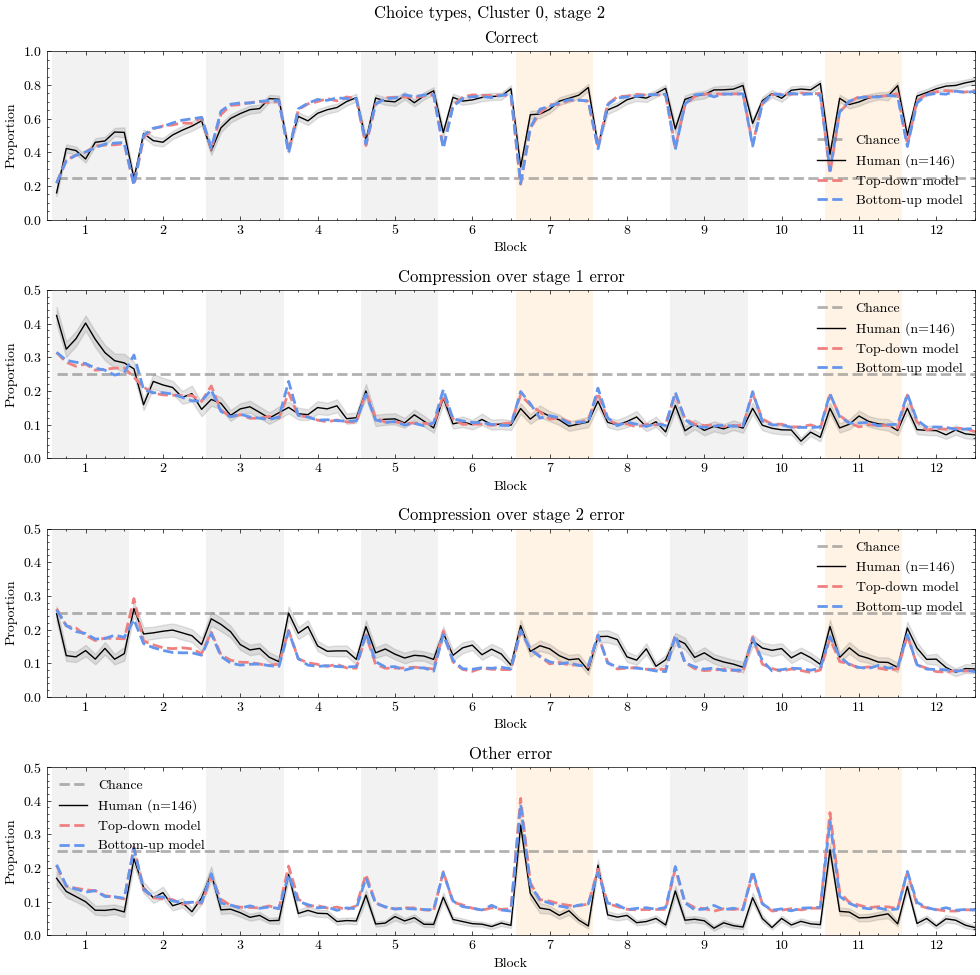

In [129]:
this_data = helpers.slice_data(all_data, meta_data, condition, exp=[1,2], cluster=cluster)
plotting.plot_validation_error_types(this_data, data_sim_forward, data_sim_backward, condition, cluster)

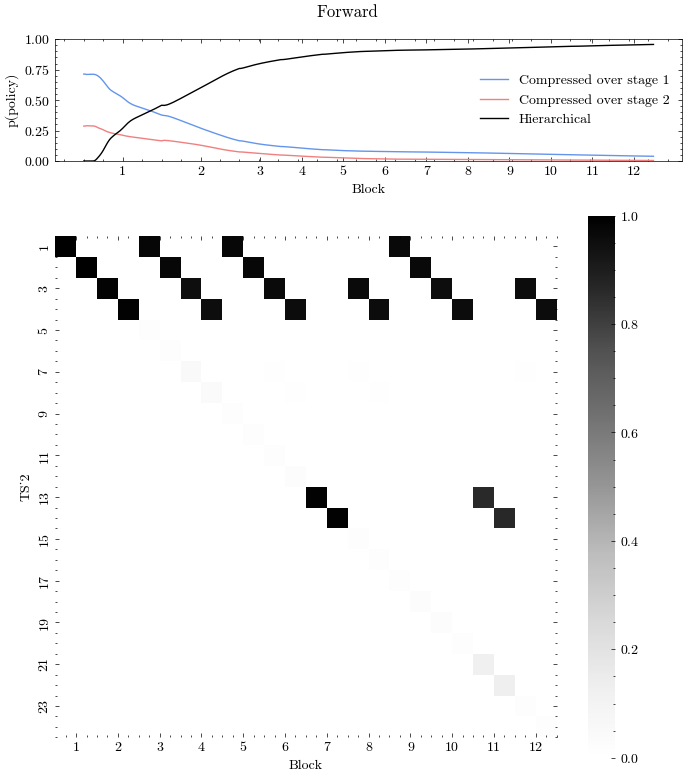

In [130]:
plotting.plot_validation_PTS(data_sim_forward, 'Forward', condition, ntrials=5, pallette='V1')

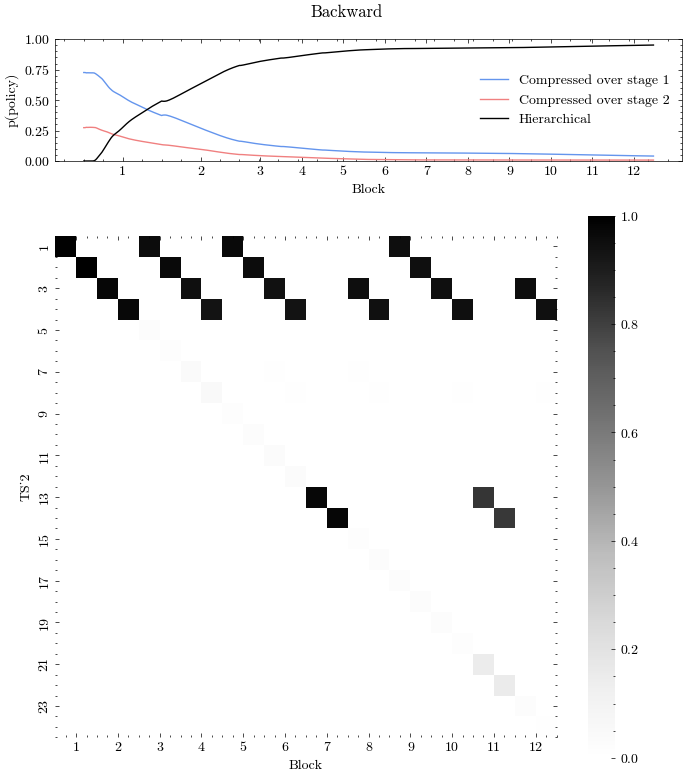

In [131]:
plotting.plot_validation_PTS(data_sim_backward, 'Backward', condition, ntrials=5, pallette='V1')

### V2-V2

In [132]:
condition = 'V2-V2'
subject_inds = (meta_data['Condition'] == condition) & (meta_data['Cluster'] == cluster)

if __name__ == "__main__":
    inputs = []
    inputs_2 = []
    for i in range(best_params_all_forward[subject_inds].shape[0]):
        params = best_params_all_forward[subject_inds][i,:]
        inputs.append((this_model, i, niters_sim, params, condition, 'forward', True))
        params = best_params_all_backward[subject_inds][i,:]
        inputs_2.append((this_model, i, niters_sim, params, condition, 'backward', True))
        
    with Pool() as p:
        results = p.map(modeling.parallel_simulator, inputs)

    data_sim_forward = {}
    for _, this_data in results:
        data_sim_forward = helpers.concatenate_data(this_data, data_sim_forward)

    with Pool() as p:
        results = p.map(modeling.parallel_simulator, inputs_2)

    data_sim_backward = {}
    for _, this_data in results:
        data_sim_backward = helpers.concatenate_data(this_data, data_sim_backward)

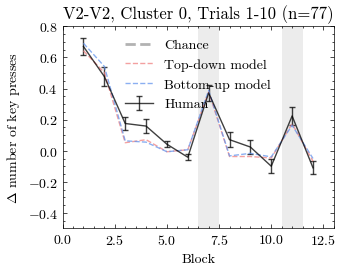

In [133]:
this_data = helpers.slice_data(all_data, meta_data, condition, exp=[1,2], cluster=cluster)
plotting.plot_validation_n_presses(this_data, data_sim_forward, data_sim_backward, condition, cluster, save_vector=True, normalize=True)

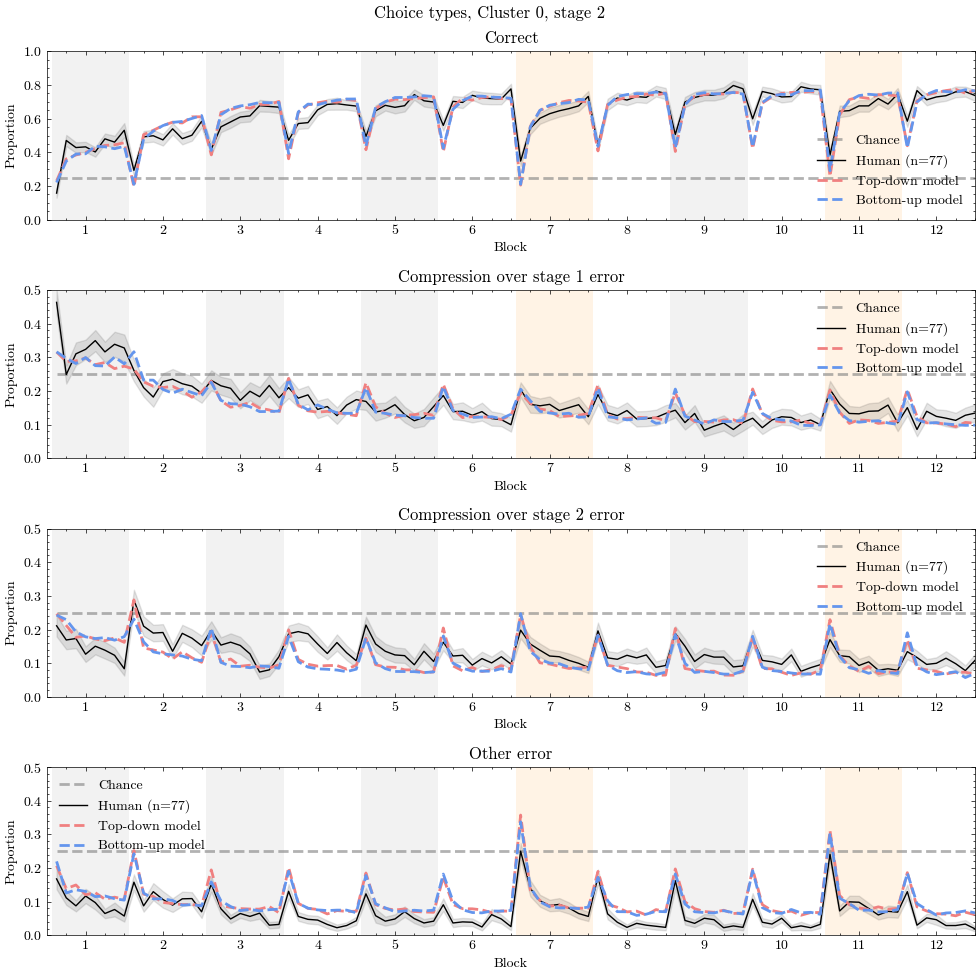

In [134]:
this_data = helpers.slice_data(all_data, meta_data, condition, exp=[1,2], cluster=cluster)
plotting.plot_validation_error_types(this_data, data_sim_forward, data_sim_backward, condition, cluster)

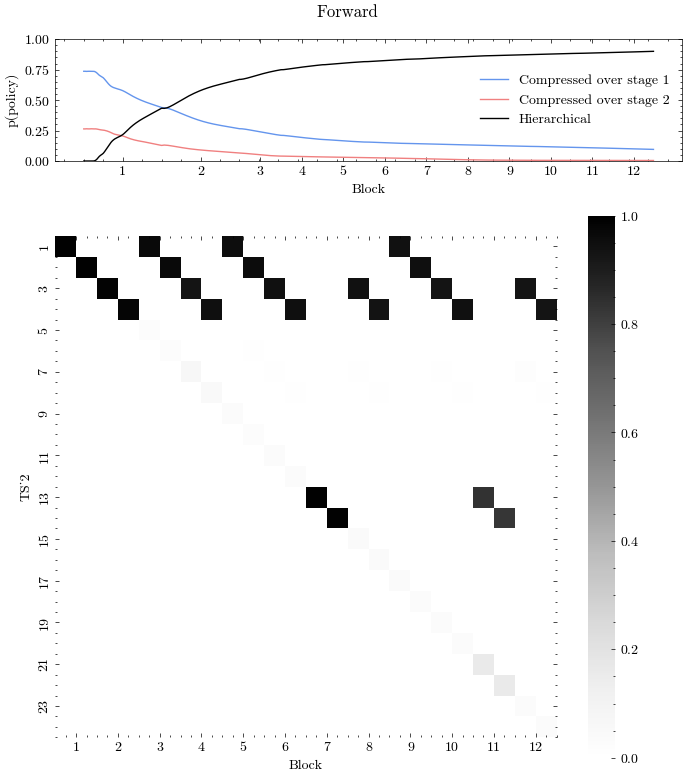

In [135]:
plotting.plot_validation_PTS(data_sim_forward, 'Forward', condition, ntrials=5, pallette='V2')

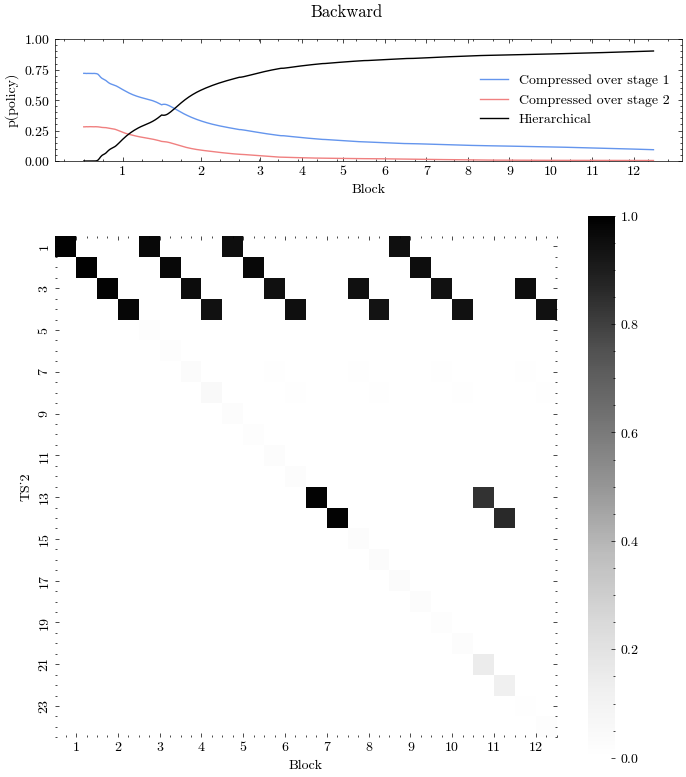

In [136]:
plotting.plot_validation_PTS(data_sim_backward, 'Backward', condition, ntrials=5, pallette='V2')

### V3-V3

In [137]:
condition = 'V3-V3'
subject_inds = (meta_data['Condition'] == condition) & (meta_data['Cluster'] == cluster)

if __name__ == "__main__":
    inputs = []
    inputs_2 = []
    for i in range(best_params_all_forward[subject_inds].shape[0]):
        params = best_params_all_forward[subject_inds][i,:]
        inputs.append((this_model, i, niters_sim, params, condition, 'forward', True))
        params = best_params_all_backward[subject_inds][i,:]
        inputs_2.append((this_model, i, niters_sim, params, condition, 'backward', True))
        
    with Pool() as p:
        results = p.map(modeling.parallel_simulator, inputs)

    data_sim_forward = {}
    for _, this_data in results:
        data_sim_forward = helpers.concatenate_data(this_data, data_sim_forward)

    with Pool() as p:
        results = p.map(modeling.parallel_simulator, inputs_2)

    data_sim_backward = {}
    for _, this_data in results:
        data_sim_backward = helpers.concatenate_data(this_data, data_sim_backward)

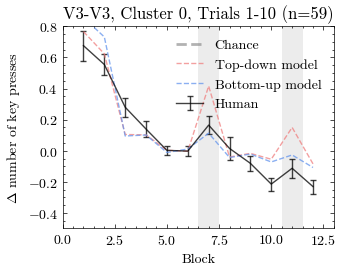

In [138]:
this_data = helpers.slice_data(all_data, meta_data, condition, exp=[1,2], cluster=cluster)
plotting.plot_validation_n_presses(this_data, data_sim_forward, data_sim_backward, condition, cluster, save_vector=True, normalize=True)

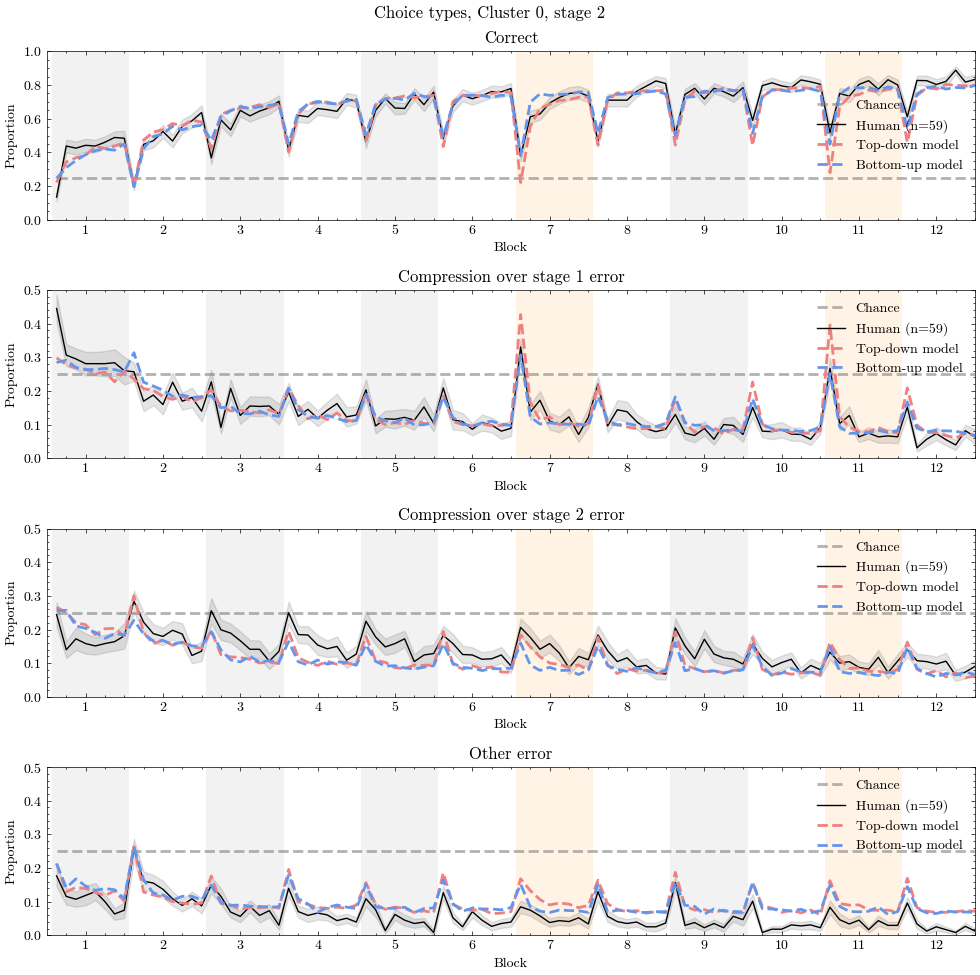

In [139]:
this_data = helpers.slice_data(all_data, meta_data, condition, exp=[1,2], cluster=cluster)
plotting.plot_validation_error_types(this_data, data_sim_forward, data_sim_backward, condition, cluster)

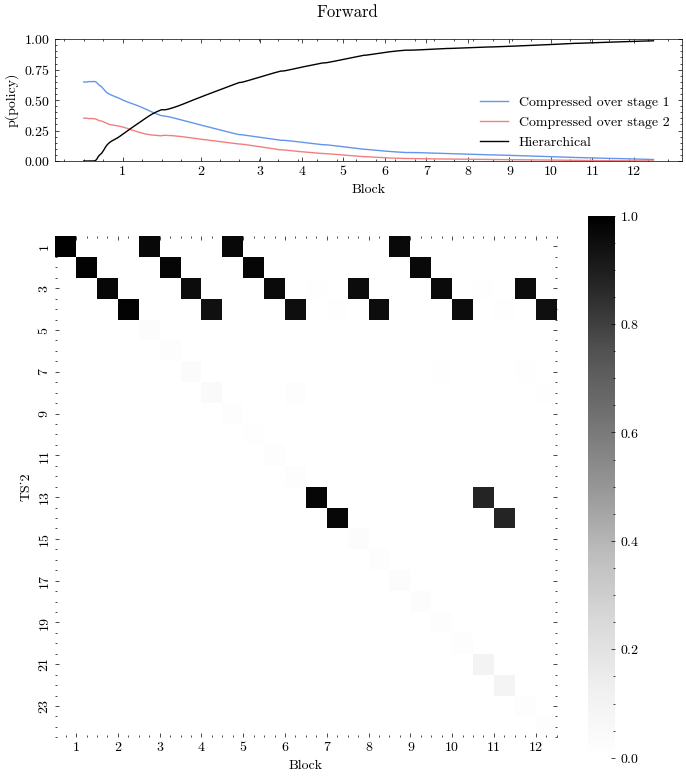

In [140]:
plotting.plot_validation_PTS(data_sim_forward, 'Forward', condition, ntrials=5, pallette='V3', save_vector=True)

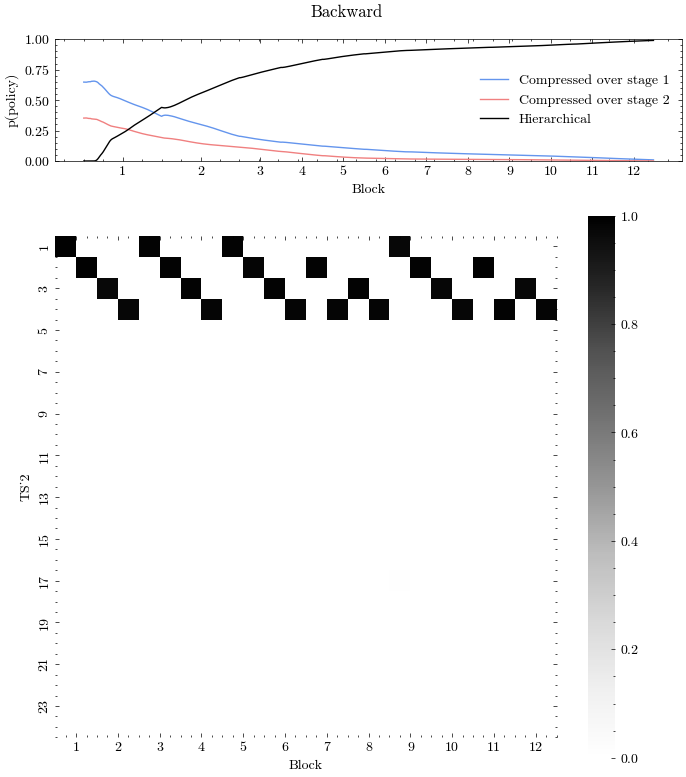

In [141]:
plotting.plot_validation_PTS(data_sim_backward, 'Backward', condition, ntrials=5, pallette='V3', save_vector=True)

### V1-V2

In [142]:
condition = 'V1-V2'
subject_inds = (meta_data['Condition'] == condition) & (meta_data['Cluster'] == cluster)

if __name__ == "__main__":
    inputs = []
    inputs_2 = []
    for i in range(best_params_all_forward[subject_inds].shape[0]):
        params = best_params_all_forward[subject_inds][i,:]
        inputs.append((this_model, i, niters_sim, params, condition, 'forward', True))
        params = best_params_all_backward[subject_inds][i,:]
        inputs_2.append((this_model, i, niters_sim, params, condition, 'backward', True))
        
    with Pool() as p:
        results = p.map(modeling.parallel_simulator, inputs)

    data_sim_forward = {}
    for _, this_data in results:
        data_sim_forward = helpers.concatenate_data(this_data, data_sim_forward)

    with Pool() as p:
        results = p.map(modeling.parallel_simulator, inputs_2)

    data_sim_backward = {}
    for _, this_data in results:
        data_sim_backward = helpers.concatenate_data(this_data, data_sim_backward)

/home/exouser/Desktop/jingjing/learning_hierarchy/helpers.py:918: RuntimeWarning: Mean of empty slice
  mean_population_counter1 = np.hstack((mean_population_counter1_12, np.nanmean(data_counter1[:,:,start_trial:int(start_trial+trials_to_probe)],axis=2)))
/home/exouser/Desktop/jingjing/learning_hierarchy/helpers.py:919: RuntimeWarning: Mean of empty slice
  mean_population_counter2 = np.hstack((mean_population_counter2_12, np.nanmean(data_counter2[:,:,start_trial:int(start_trial+trials_to_probe)],axis=2)))


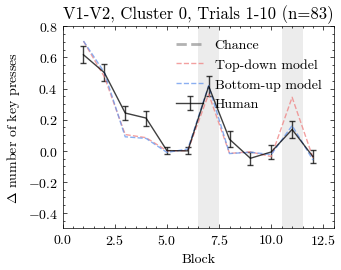

In [143]:
this_data = helpers.slice_data(all_data, meta_data, condition, exp=[1,2], cluster=cluster)
plotting.plot_validation_n_presses(this_data, data_sim_forward, data_sim_backward, condition, cluster, save_vector=True, normalize=True)

In [144]:
this_data = helpers.slice_data(all_data, meta_data, 'V1-V2', exp=[1,2], cluster=0)
_, n_presses_stage_2 = helpers.calc_mean(this_data, start_trial=0, trials_to_probe=10, first_press_accuracy=False)
n_presses_stage_2 = n_presses_stage_2[np.sum(np.isnan(n_presses_stage_2), axis=1)==0,:]
stats.ttest_rel(n_presses_stage_2[:,6], n_presses_stage_2[:,10], alternative='greater')

TtestResult(statistic=4.167098371054819, pvalue=3.835648688455166e-05, df=81)

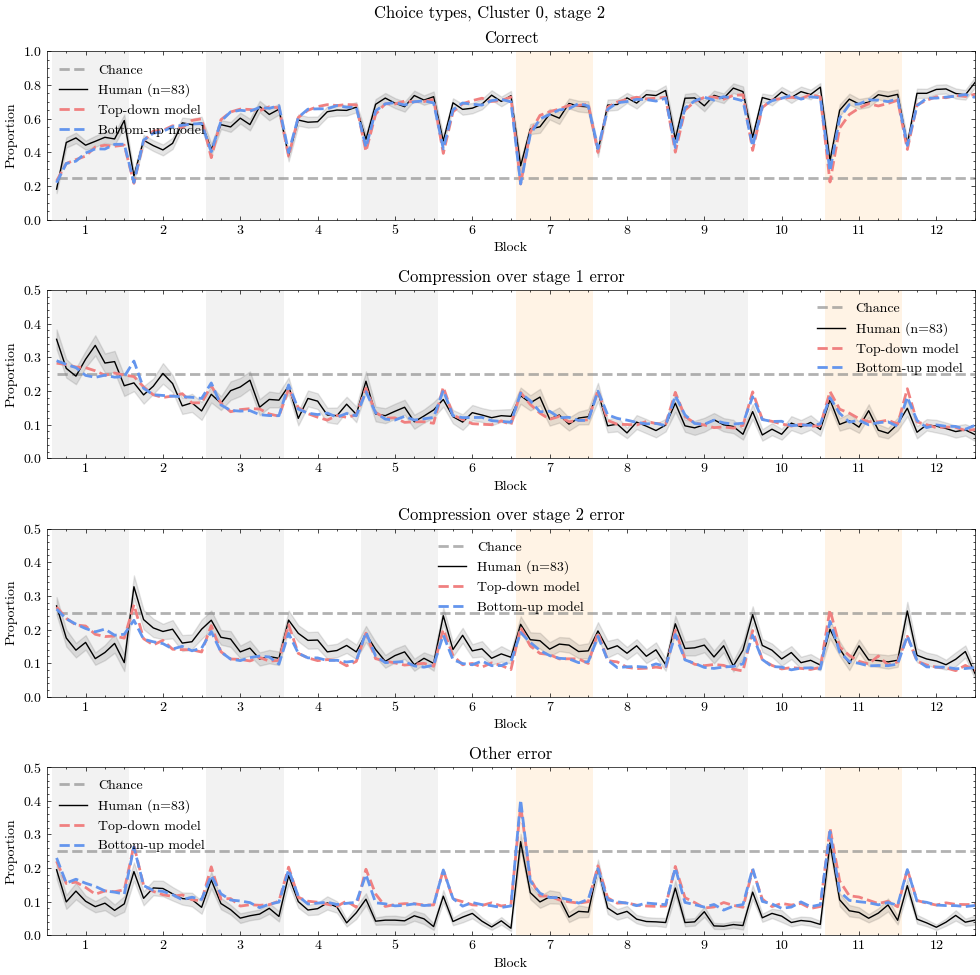

In [145]:
this_data = helpers.slice_data(all_data, meta_data, condition, exp=[1,2], cluster=cluster)
plotting.plot_validation_error_types(this_data, data_sim_forward, data_sim_backward, condition, cluster, save_vector=True)

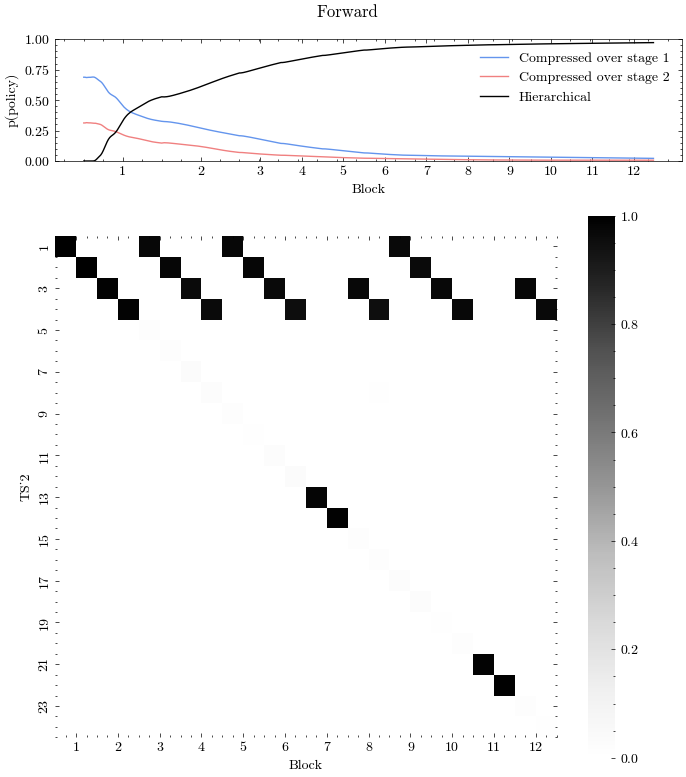

In [146]:
plotting.plot_validation_PTS(data_sim_forward, 'Forward', condition, ntrials=5, pallette='V1', save_vector=True)

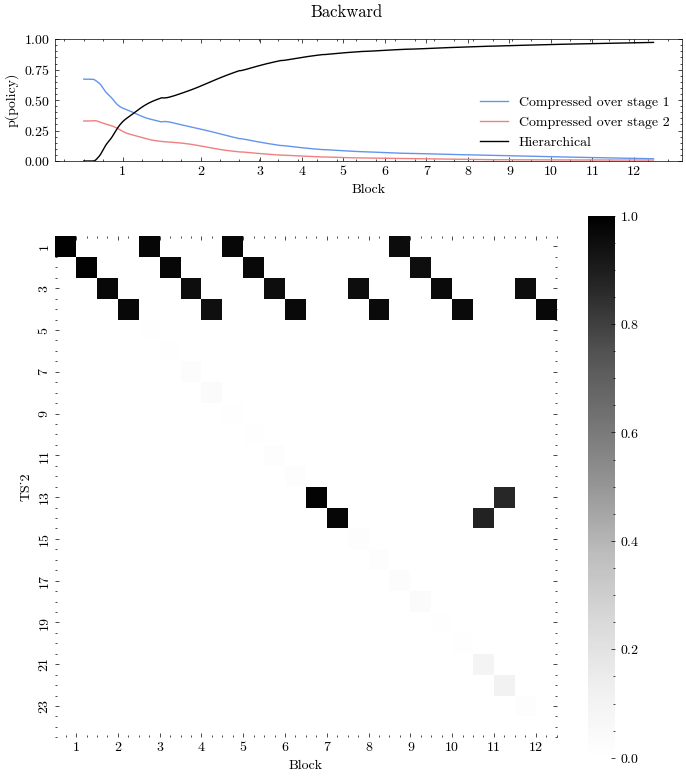

In [147]:
plotting.plot_validation_PTS(data_sim_backward, 'Backward', condition, ntrials=5, pallette='V1', save_vector=True)

### V2-V1

In [148]:
condition = 'V2-V1'
subject_inds = (meta_data['Condition'] == condition) & (meta_data['Cluster'] == cluster)

if __name__ == "__main__":
    inputs = []
    inputs_2 = []
    for i in range(best_params_all_forward[subject_inds].shape[0]):
        params = best_params_all_forward[subject_inds][i,:]
        inputs.append((this_model, i, niters_sim, params, condition, 'forward', True))
        params = best_params_all_backward[subject_inds][i,:]
        inputs_2.append((this_model, i, niters_sim, params, condition, 'backward', True))
        
    with Pool() as p:
        results = p.map(modeling.parallel_simulator, inputs)

    data_sim_forward = {}
    for _, this_data in results:
        data_sim_forward = helpers.concatenate_data(this_data, data_sim_forward)

    with Pool() as p:
        results = p.map(modeling.parallel_simulator, inputs_2)

    data_sim_backward = {}
    for _, this_data in results:
        data_sim_backward = helpers.concatenate_data(this_data, data_sim_backward)

/home/exouser/Desktop/jingjing/learning_hierarchy/helpers.py:918: RuntimeWarning: Mean of empty slice
  mean_population_counter1 = np.hstack((mean_population_counter1_12, np.nanmean(data_counter1[:,:,start_trial:int(start_trial+trials_to_probe)],axis=2)))
/home/exouser/Desktop/jingjing/learning_hierarchy/helpers.py:913: RuntimeWarning: Mean of empty slice
  mean_population_counter1_12[sub,0] = np.nanmean(data_counter12_12[sub,0,0,start_trial:int(start_trial+trials_to_probe)])


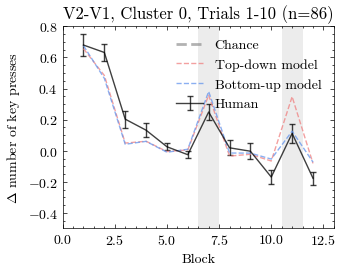

In [149]:
this_data = helpers.slice_data(all_data, meta_data, condition, exp=[1,2], cluster=cluster)
plotting.plot_validation_n_presses(this_data, data_sim_forward, data_sim_backward, condition, cluster, save_vector=True, normalize=True)

In [150]:
this_data = helpers.slice_data(all_data, meta_data, 'V2-V1', exp=[1,2], cluster=0)
_, n_presses_stage_2 = helpers.calc_mean(this_data, start_trial=0, trials_to_probe=10, first_press_accuracy=False)
stats.ttest_rel(n_presses_stage_2[:,6], n_presses_stage_2[:,10], alternative='greater')

TtestResult(statistic=2.36058166887825, pvalue=0.010267591972178903, df=85)

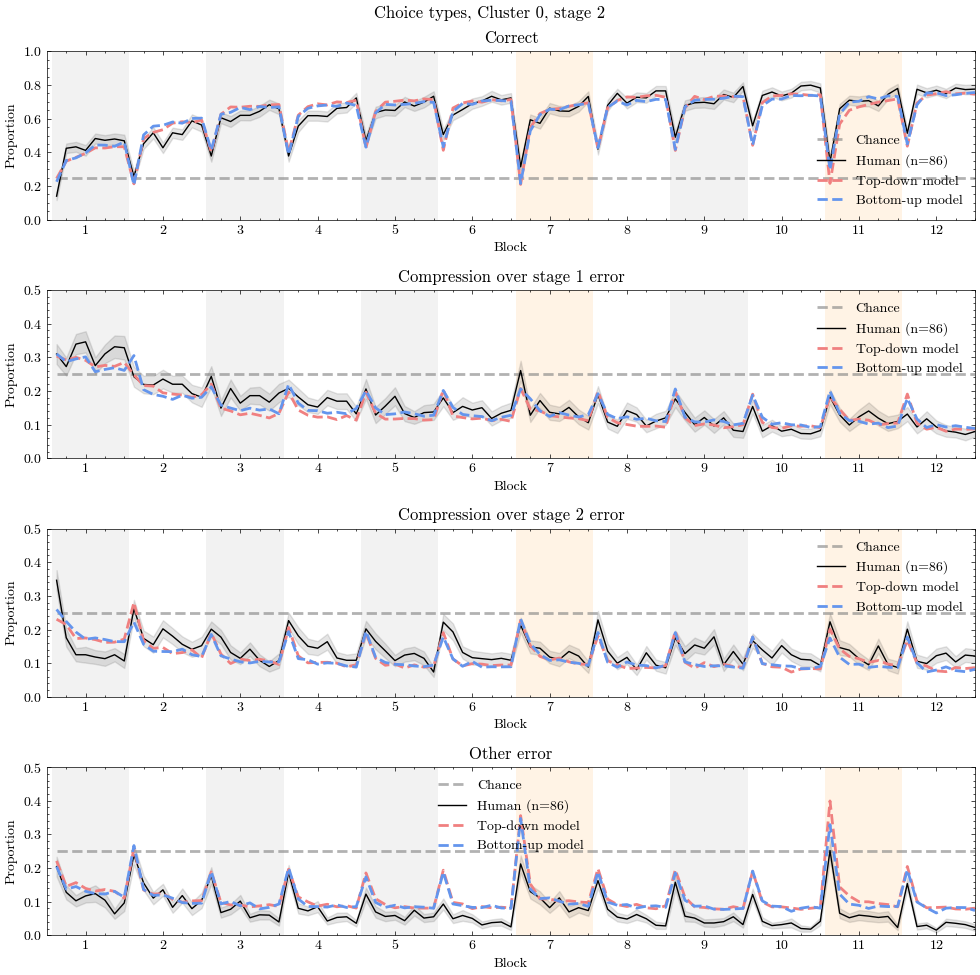

In [151]:
this_data = helpers.slice_data(all_data, meta_data, condition, exp=[1,2], cluster=cluster)
plotting.plot_validation_error_types(this_data, data_sim_forward, data_sim_backward, condition, cluster, save_vector=True)

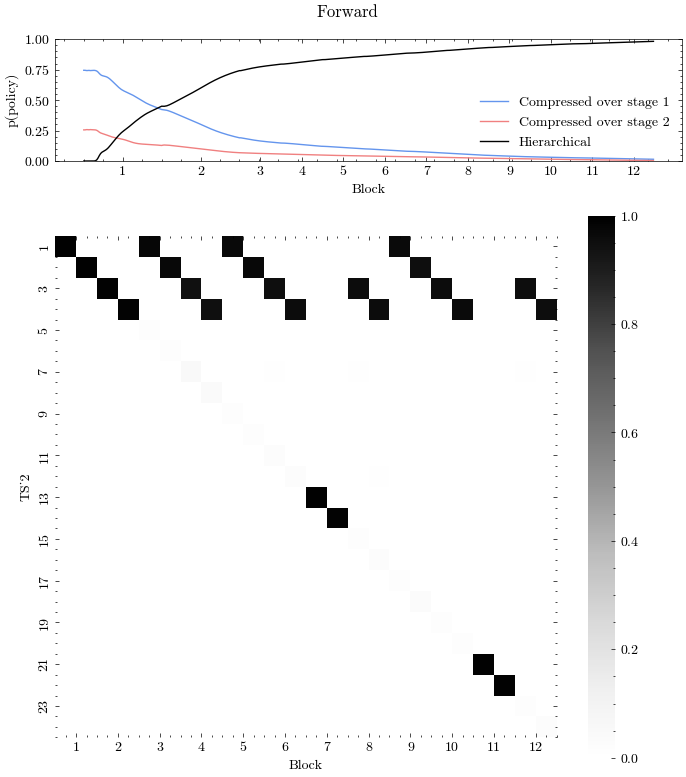

In [152]:
plotting.plot_validation_PTS(data_sim_forward, 'Forward', condition, ntrials=5, pallette='V2', save_vector=True)

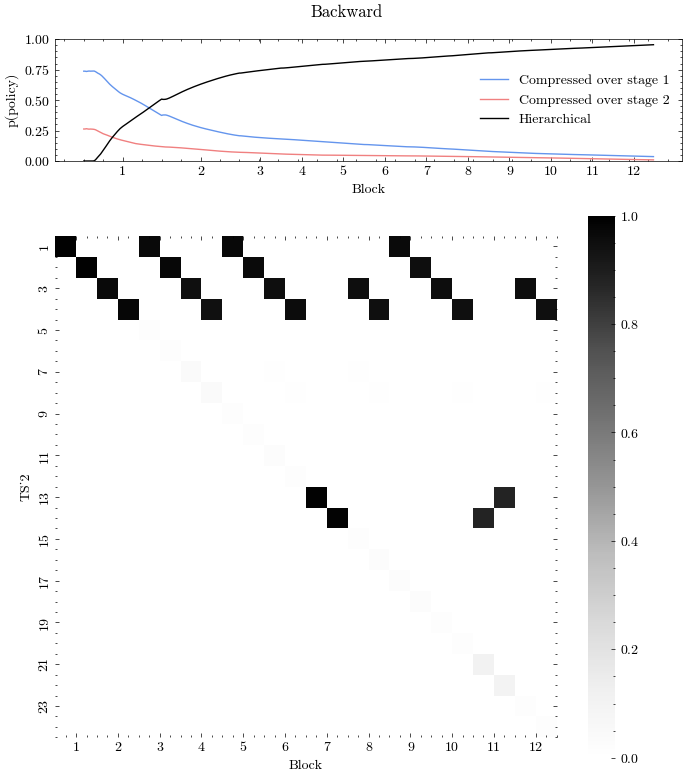

In [153]:
plotting.plot_validation_PTS(data_sim_backward, 'Backward', condition, ntrials=5, pallette='V2', save_vector=True)

### V1-V3

In [154]:
condition = 'V1-V3'
subject_inds = (meta_data['Condition'] == condition) & (meta_data['Cluster'] == cluster)

if __name__ == "__main__":
    inputs = []
    inputs_2 = []
    for i in range(best_params_all_forward[subject_inds].shape[0]):
        params = best_params_all_forward[subject_inds][i,:]
        inputs.append((this_model, i, niters_sim, params, condition, 'forward', True))
        params = best_params_all_backward[subject_inds][i,:]
        inputs_2.append((this_model, i, niters_sim, params, condition, 'backward', True))
        
    with Pool() as p:
        results = p.map(modeling.parallel_simulator, inputs)

    data_sim_forward = {}
    for _, this_data in results:
        data_sim_forward = helpers.concatenate_data(this_data, data_sim_forward)

    with Pool() as p:
        results = p.map(modeling.parallel_simulator, inputs_2)

    data_sim_backward = {}
    for _, this_data in results:
        data_sim_backward = helpers.concatenate_data(this_data, data_sim_backward)

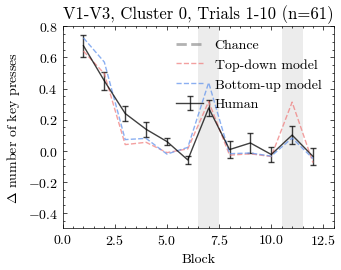

In [155]:
this_data = helpers.slice_data(all_data, meta_data, condition, exp=[1,2], cluster=cluster)
plotting.plot_validation_n_presses(this_data, data_sim_forward, data_sim_backward, condition, cluster, save_vector=True, normalize=True)

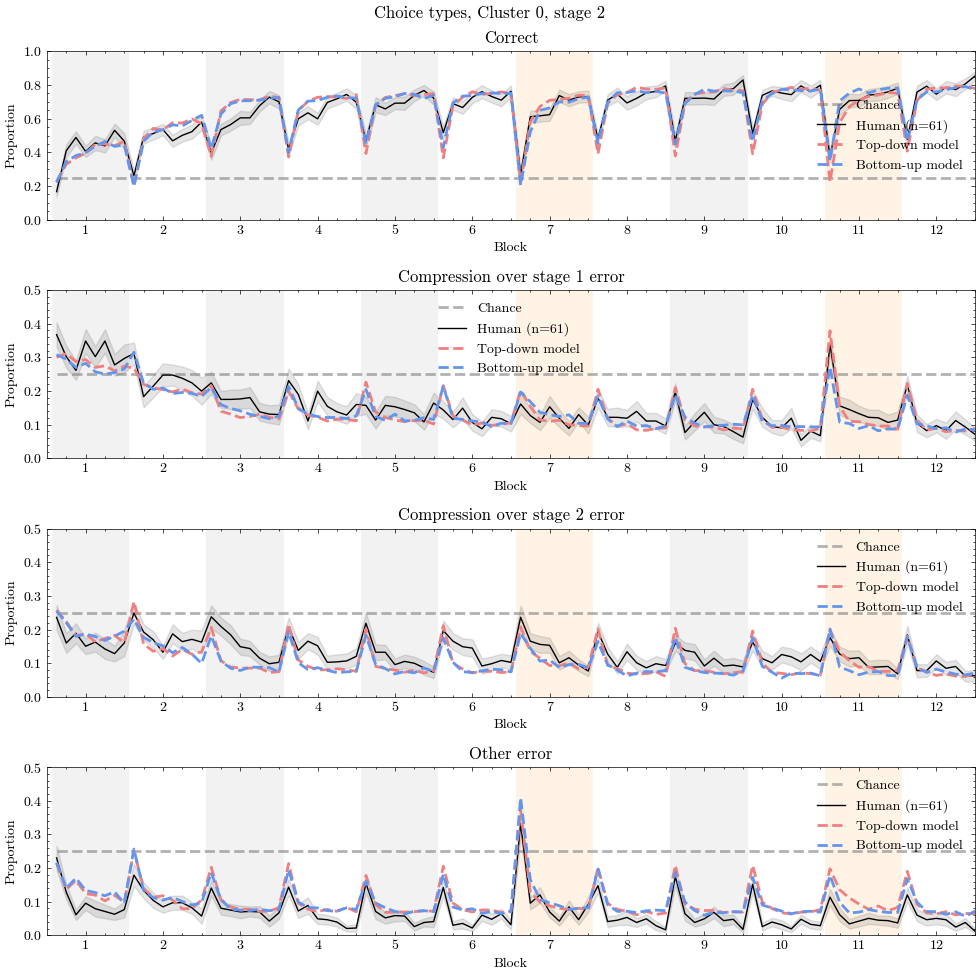

In [156]:
this_data = helpers.slice_data(all_data, meta_data, condition, exp=[1,2], cluster=cluster)
plotting.plot_validation_error_types(this_data, data_sim_forward, data_sim_backward, condition, cluster)

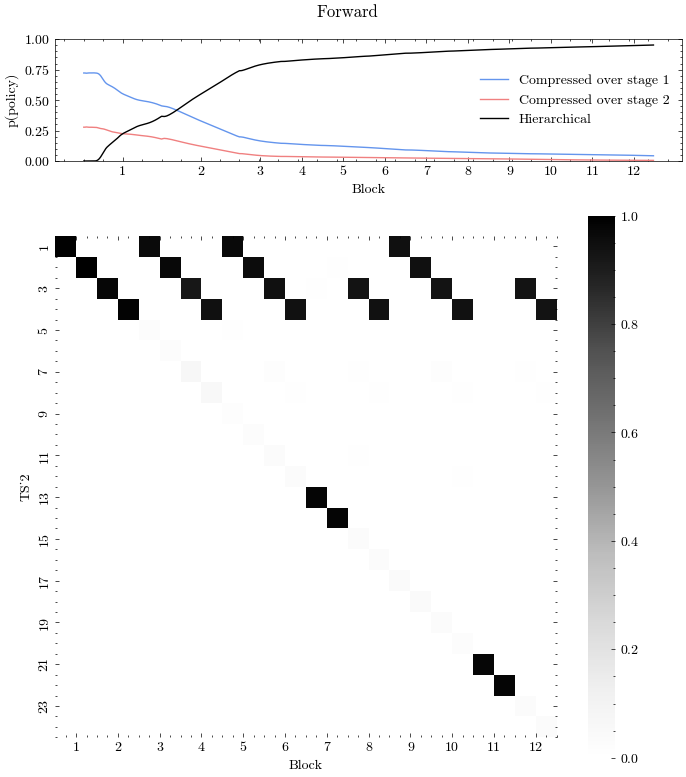

In [157]:
plotting.plot_validation_PTS(data_sim_forward, 'Forward', condition, ntrials=5, pallette='V2', save_vector=True)

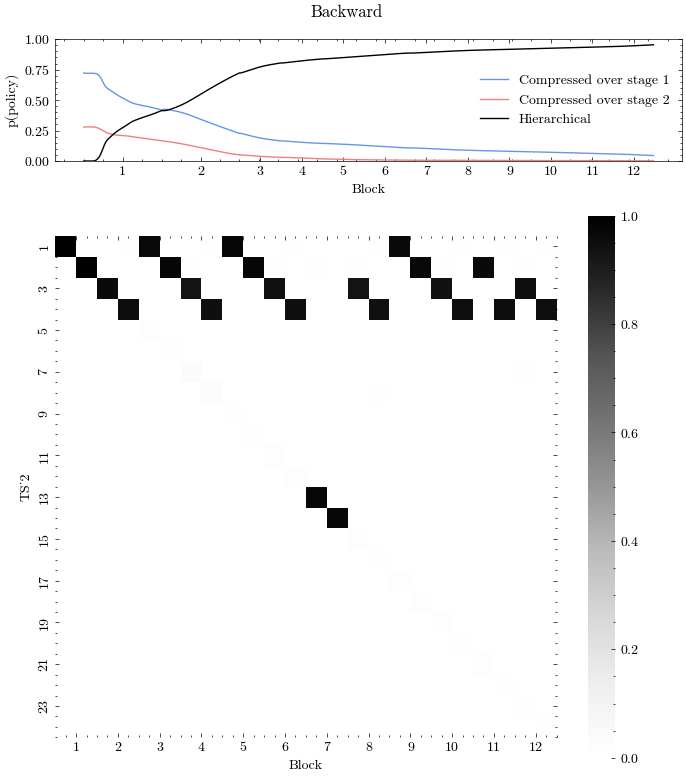

In [158]:
plotting.plot_validation_PTS(data_sim_backward, 'Backward', condition, ntrials=5, pallette='V2', save_vector=True)

### V3-V1

In [159]:
condition = 'V3-V1'
subject_inds = (meta_data['Condition'] == condition) & (meta_data['Cluster'] == cluster)

if __name__ == "__main__":
    inputs = []
    inputs_2 = []
    for i in range(best_params_all_forward[subject_inds].shape[0]):
        params = best_params_all_forward[subject_inds][i,:]
        inputs.append((this_model, i, niters_sim, params, condition, 'forward', True))
        params = best_params_all_backward[subject_inds][i,:]
        inputs_2.append((this_model, i, niters_sim, params, condition, 'backward', True))
        
    with Pool() as p:
        results = p.map(modeling.parallel_simulator, inputs)

    data_sim_forward = {}
    for _, this_data in results:
        data_sim_forward = helpers.concatenate_data(this_data, data_sim_forward)

    with Pool() as p:
        results = p.map(modeling.parallel_simulator, inputs_2)

    data_sim_backward = {}
    for _, this_data in results:
        data_sim_backward = helpers.concatenate_data(this_data, data_sim_backward)

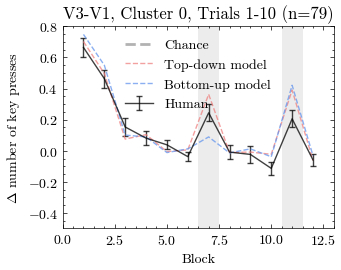

In [160]:
this_data = helpers.slice_data(all_data, meta_data, condition, exp=[1,2], cluster=cluster)
plotting.plot_validation_n_presses(this_data, data_sim_forward, data_sim_backward, condition, cluster, save_vector=True, normalize=True)

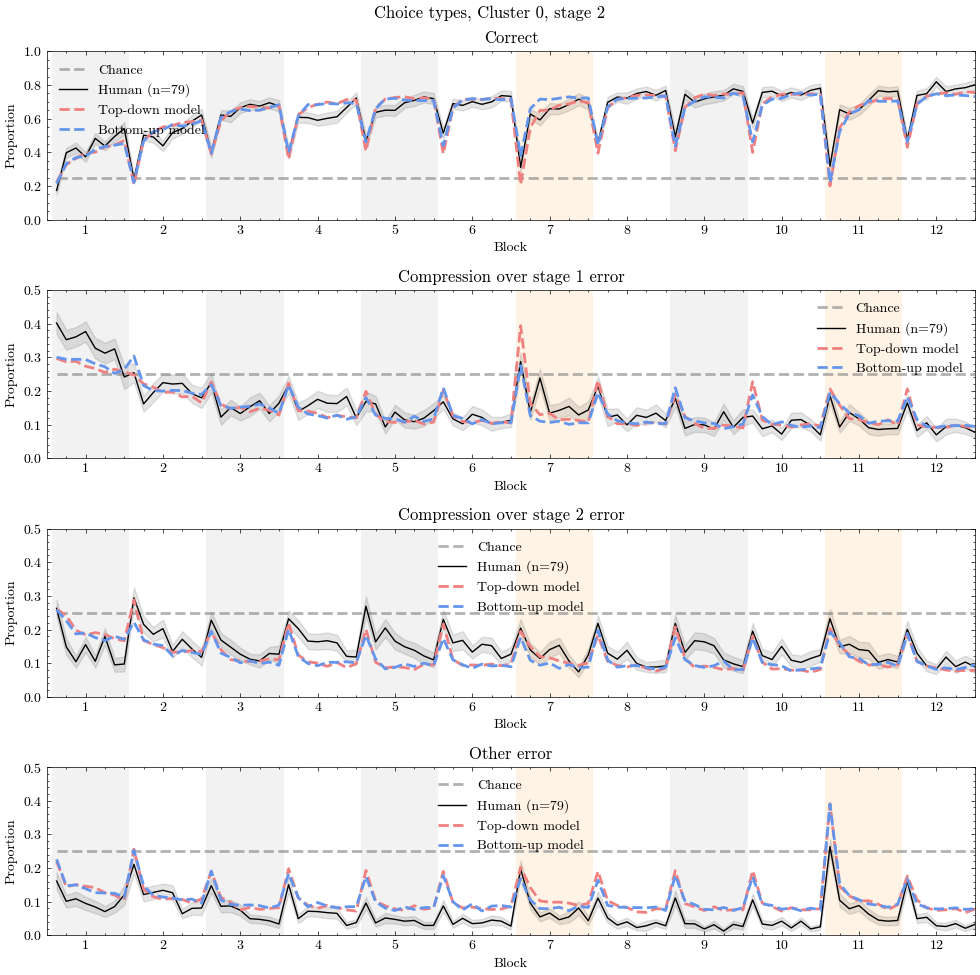

In [161]:
this_data = helpers.slice_data(all_data, meta_data, condition, exp=[1,2], cluster=cluster)
plotting.plot_validation_error_types(this_data, data_sim_forward, data_sim_backward, condition, cluster)

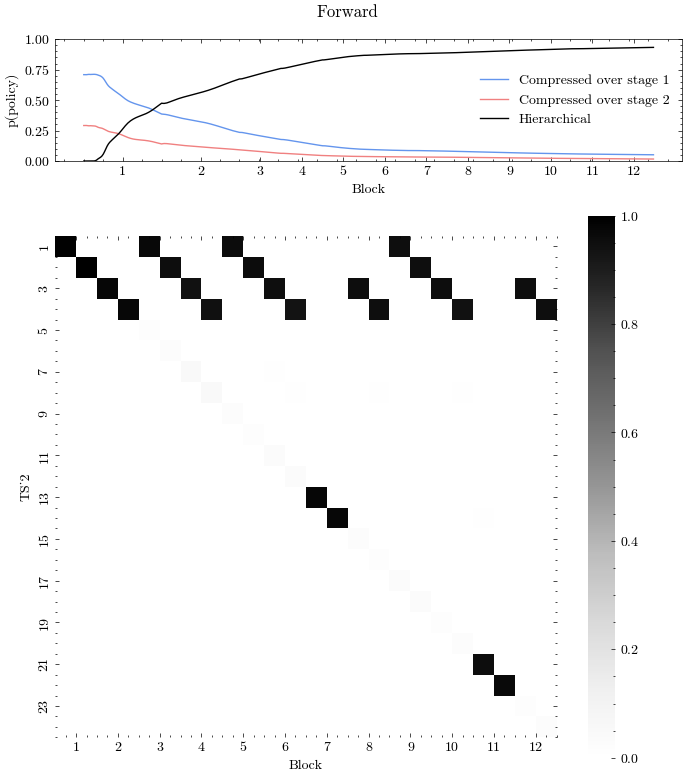

In [162]:
plotting.plot_validation_PTS(data_sim_forward, 'Forward', condition, ntrials=5, pallette='V2', save_vector=True)

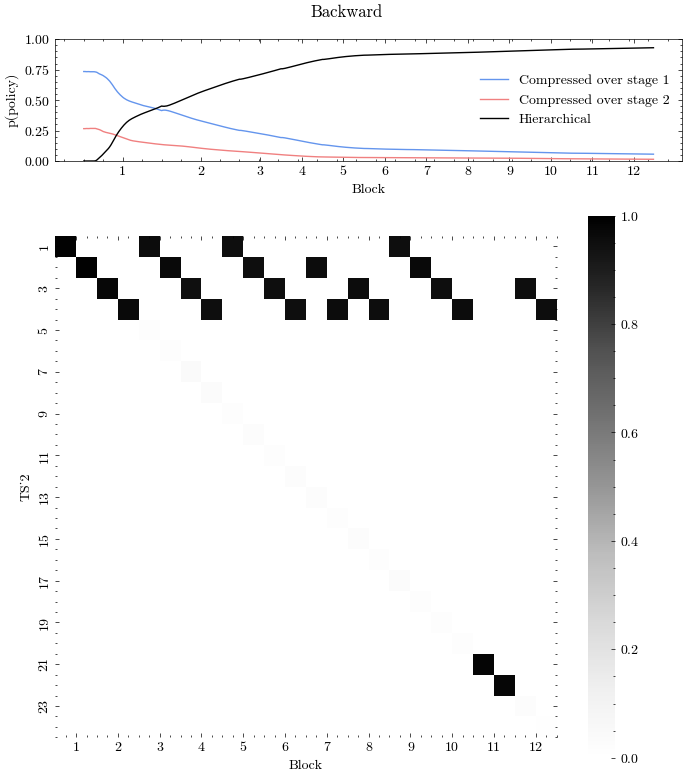

In [163]:
plotting.plot_validation_PTS(data_sim_backward, 'Backward', condition, ntrials=5, pallette='V2', save_vector=True)